# The review for dynamical entanglement


In [27]:
# run this unit first. this unit includes all functions that we used.

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import time
import math


# Operators
N = 2  # Two-level system for each emitter
Na = 6  # Cavity photon number truncation, make sure Na is much smaller than <a^+a>
sigma_1 = tensor(sigmam(), qeye(N), qeye(Na))  # Lowering operator for emitter 1
sigma_2 = tensor(qeye(N), sigmam(), qeye(Na))  # Lowering operator for emitter 2
N1 = sigma_1.dag() * sigma_1 
N2 = sigma_2.dag() * sigma_2
a = tensor(qeye(N), qeye(N), destroy(Na))  # Photon annihilation operator
S = sigma_1 + sigma_2  # Collective spin operator

# Initial and target states
psi_0 = tensor(basis(N, 0), basis(N, 1), basis(Na, 0))  # Initial state |100>
phi = (tensor(basis(N, 0), basis(N, 1)) - 1j * tensor(basis(N, 1), basis(N, 0))) / math.sqrt(2)  # Target state |phi>=(|10>-i|01>)/sqrt(2)

# trace the cavity mose, we get effective operators without the cavity mode
sigma_1_eff = tensor(sigmam(), qeye(N))  # Effective lowering operator for emitter 1
sigma_2_eff = tensor(qeye(N), sigmam())  # Effective lowering operator for emitter 2
N1_eff = sigma_1_eff.dag() * sigma_1_eff
N2_eff = sigma_2_eff.dag() * sigma_2_eff
S_eff = sigma_1_eff + sigma_2_eff  # Effective collective operator
psi_0_eff = tensor(basis(N, 0), basis(N, 1))  # Effective initial state

# define functions to calculate the master equation
def dC_dynamics_full():
    H_full = Delta * (N1 + N2) + g * (a * S.dag() + a.dag() * S) # origin Hamiltonian
    colps_full = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a] # Lindblad terms
    data_full = mesolve(H_full, psi_0, times, colps_full, []) # solve master equation
    F_full = [fidelity(phi, state.ptrace((0, 1))) for state in data_full.states] # calculate the fidelity for rho(t) that we get from data_full.states
    N_aa = [expect(a.dag() * a, state) for state in data_full.states] # calculate the average photon number
    return F_full, N_aa # output

def dC_dynamics_eff():
    Gamma = g**2 * kappa / (Delta**2 + kappa**2 / 4)
    H_eff = Delta * (N1_eff + N2_eff) + J * S_eff.dag() * S_eff # effective Hamiltonian
    colps_eff = [math.sqrt(gamma) * sigma_1_eff, math.sqrt(gamma) * sigma_2_eff, math.sqrt(Gamma) * S_eff] # Lindblad terms
    data_eff = mesolve(H_eff, psi_0_eff, times, colps_eff, []) # solve master equation
    F_eff = [fidelity(phi, state) for state in data_eff.states] # calculate the fidelity for rho(t) that we get from data_eff.states
    return F_eff # output

print('Functions are ready')

Functions are ready


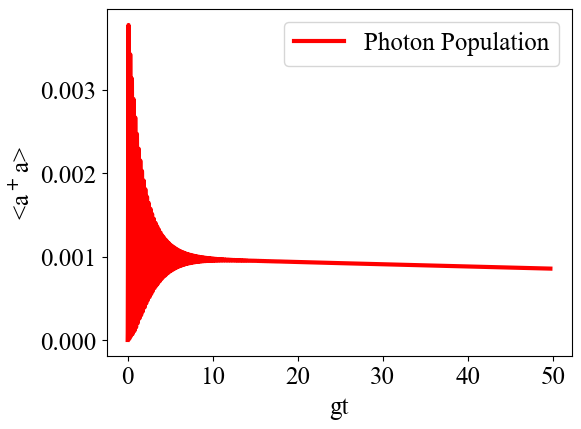

Running time: 1.32 s


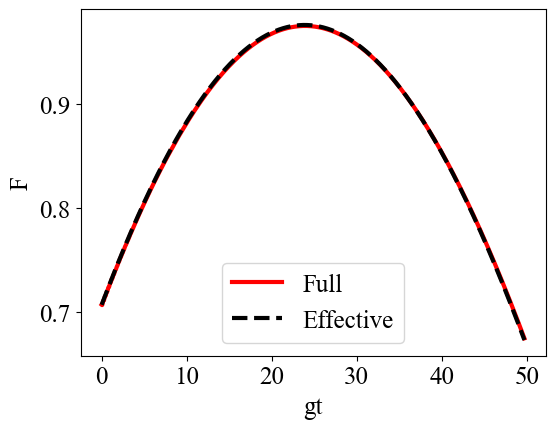

In [29]:
# This unit is for the evolution of fidelity

# Start timing
start_time = time.time()

# parameters
g = 1  # Coupling strength, unit 1
kappa = 1 * g  # decay, make sure kappa << Delta
C = 10**3  # Cooperativity, adjustable
gamma = g**2 / (kappa * C) # Spontaneous radiance rate of emitter
Delta = g * (kappa / gamma)**0.5 # detuning, make sure Delta >> g, kappa
J = g**2 * Delta / (Delta**2 + kappa**2 / 4) # Coherent coupling induced by cavity
Gamma = g**2 * kappa / (Delta**2 + kappa**2 / 4) # collective decay induced by cavity
T = np.pi / (2 * J)  # Half period
Nt = int(T * 100)  # Number of time steps
times = np.linspace(0, T, Nt)  # Time array for simulation

# Execute the dynamics calculations
F_full, N_aa = dC_dynamics_full()
F_eff = dC_dynamics_eff()

# Plotting and saving results
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))
plt.plot(times, N_aa, label='Photon Population', linewidth=3, color='r')
plt.xlabel('gt')
plt.ylabel('<a$^+$a>')
plt.legend(loc='best')
plt.show()

plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))
plt.plot(times, F_full, label='Full', linewidth=3, color='r')
plt.plot(times, F_eff, label='Effective', linewidth=3, linestyle='--', color='k')
plt.xlabel('gt')
plt.ylabel('F')
plt.legend(loc='best')
plt.legend()

# Save data in .txt file
np.savetxt('dC_F_t.txt', np.column_stack((times, F_full, F_eff)), delimiter=' ')

# End timing and print execution time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")


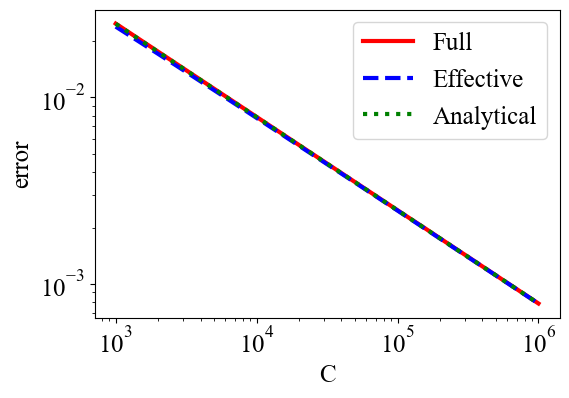

Running time: 477.76 s


In [35]:
# This unit is for the scaling of cooperativity C


# Start timing
start_time = time.time()

# parameters
g = 1  # Coupling strength, unit 1
kappa = 1 * g  # decay, make sure kappa << Delta
M = 30  # data point
log_dC = np.linspace(3, 6, M)  # log10(C)
dC = np.power(10, log_dC)  # run cooperativity from 1000 to 1000000
dgamma = g**2 / kappa / dC  # gamma changes with cooperativity
epsilon_full = np.zeros(M)  # array for saving data
epsilon_eff = np.zeros(M)  # array for saving data

# Calculate
for j in range(M):
    C = dC[j]  # pick each cooperativity
    gamma = dgamma[j]  # emitter decay
    Delta = g * (kappa / gamma)**0.5  # optimal detuning
    J = g**2 * Delta / (Delta**2 + kappa**2/4)  # effective coherent coupling
    Gamma = g**2 * kappa / (Delta**2 + kappa**2/4)  # collective decay rate
    T = np.pi / (2 * J)  # half period
    Nt = int(T * 50)  # time step
    times = np.linspace(0, T, Nt)  # time list
    epsilon_full[j] = 1 - np.max(dC_dynamics_full()[0])  # solution from full master equation
    epsilon_eff[j] = 1 - np.max(dC_dynamics_eff())  # solution from effective master equation

epsilon_ana = (np.pi / 4 / dC**0.5)  # analytical solution


# Plot figure
plt.figure(figsize=(6, 4))
plt.plot(dC, epsilon_full, label='Full', linewidth=3, linestyle='-', color='r')
plt.plot(dC, epsilon_eff, label='Effective', linewidth=3, linestyle='--', color='b')
plt.plot(dC, epsilon_ana, label='Analytical', linewidth=3, linestyle=':', color='g')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('error')
plt.legend(loc='best')
plt.show()

# Save the data in .txt file
combined_array = np.column_stack((dC, epsilon_full, epsilon_eff, epsilon_ana))
file_path = 'dC_error_C.txt'
np.savetxt(file_path, combined_array, delimiter=' ')

# End timing
end_time = time.time()
# Print the time
execution_time = end_time - start_time
print(f"Running time: {execution_time:.2f} s")
